In [429]:
import pandas as pd
import numpy as np
import sklearn.preprocessing as pr
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
data = pd.read_csv("train.csv",encoding="latin-1")
data.shape

(1143, 75)

In [433]:
data.head()

,surveyid,village,survey_date,femaleres,age,married,children,hhsize,edu,hh_children,...,given_mpesa,amount_given_mpesa,received_mpesa,amount_received_mpesa,net_mpesa,saved_mpesa,amount_saved_mpesa,early_survey,depressed,day_of_week
0,926,91,23-Nov-61,1,28.0,1,4,6,10,0,...,0,0.0,0,0.000000,0.000000,1,0.000000,0,0,5
1,747,57,24-Oct-61,1,23.0,1,3,5,8,0,...,0,0.0,1,4.804611,4.804611,0,0.000000,0,1,3
2,1190,115,05-Oct-61,1,22.0,1,3,5,9,0,...,0,0.0,0,8.007685,8.007685,1,0.000000,0,0,5
3,1065,97,23-Sep-61,1,27.0,1,2,4,10,2,...,0,0.0,0,0.000000,0.000000,1,1.249199,0,0,0
4,806,42,12-Sep-61,0,59.0,0,4,6,10,4,...,0,0.0,0,0.000000,0.000000,0,0.000000,0,0,3


# Data Prepocessing

### Plot Missing Data Percentages

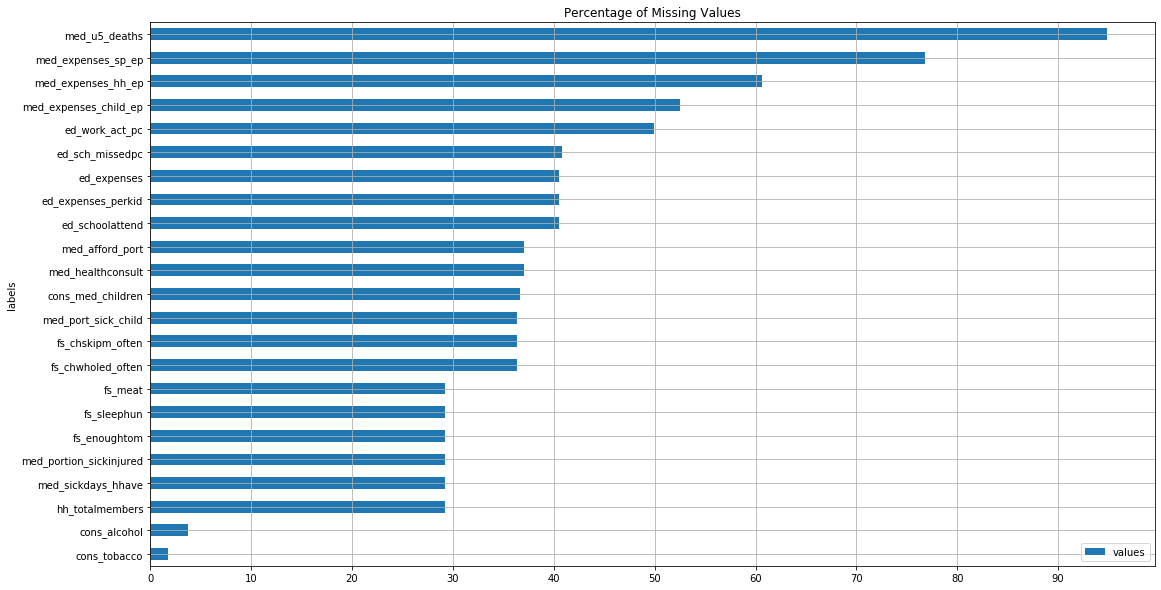

In [391]:
labels=[]
values=[]
for column in data.columns:
  if (data[column].isnull().sum()) > 0:
    labels.append(column)
    values.append(100*(data[column].isnull().sum()/len(data)))
data_missing = pd.DataFrame(list(zip(labels,values)), columns = ['labels','values'])
data_missing = data_missing.sort_values(by='values', ascending = True)
data_missing.plot(x='labels', y='values',kind='barh',xticks=np.arange(0,100,10), grid=True, figsize=(18,10),title="Percentage of Missing Values")
plt.show()
#print(data_missing)

### Data Cleaning

In [392]:
def data_cleaning(ratio,drop_date):
    global data
    #Drop Columns with NaN ratio is greater than 'ratio'
    for i in data.columns:
        if (100*(data[i].isnull().sum()/len(data))>ratio):
            print(i,' ',100*(data[i].isnull().sum()/len(data)))
            del data[i]        
    #Drop Columns with unnecessary info
    del data['surveyid']
    if (drop_date=='y'):
        del data['survey_date']
    else:
        from sklearn.preprocessing import LabelEncoder
        encoder = LabelEncoder()
        encoder.fit(data['survey_date'])
        data['survey_date'] = encoder.transform(data['survey_date'])
    #Round age values to nearest integer
    data['age']=data['age'].round()
    data.shape

In [393]:
data_cleaning(ratio=49.0,drop_date='n')

med_expenses_hh_ep   60.629921259842526
med_expenses_sp_ep   76.8153980752406
med_expenses_child_ep   52.493438320209975
med_u5_deaths   94.83814523184601
ed_work_act_pc   49.95625546806649


### Filling NaN

In [396]:
def Fill_NaN(estimator):
    global data
    if (estimator=='mean'):    
        # Fill with Mean
        data=data.fillna(data.mean())
    if (estimator=='regression'):
        # Fill with Beyesian Ridge Regression
        from sklearn.experimental import enable_iterative_imputer  
        from sklearn.impute import IterativeImputer
        imputer_estimator = IterativeImputer(random_state=0)
        imputer_estimator.fit(data)
        data_values=imputer_estimator.transform(data)
        data=pd.DataFrame(data_values, columns = data.columns)

In [397]:
Fill_NaN('regression');data.shape

(1143, 69)

### Divide data to X and Y

In [398]:
X = data.drop(["depressed"], axis=1)
Y=data.depressed

# Split The Data to Train and Test Set


In [422]:
# Split Train and Test
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25)
print("Length of X_train %d, X_test: %d, Y_train: %d, Y_test: %d" %(len(X_train), len(X_test), len(Y_train), len(Y_test)))

Length of X_train 857, X_test: 286, Y_train: 857, Y_test: 286


# Random Forest Classifier

### 1. Random Search Training


In [400]:
from sklearn.ensemble import RandomForestClassifier
RFC = RandomForestClassifier(random_state = 42)
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(RFC.get_params())

Parameters currently in use:

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 'warn',
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [220]:
#from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

n_estimators = [int(x) for x in np.linspace(start = 10, stop = 150, num = 70)]
max_features = ['auto']
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
max_depth.append(None)
min_samples_split = [2, 4, 6, 8, 10]
min_samples_leaf = [1,2,4,6,8,10]
bootstrap = [True, False]
#random_grid = {'n_estimators': n_estimators,
#               'max_features': max_features,
 #              'max_depth': max_depth,
  #             'min_samples_split': min_samples_split,
   #            'min_samples_leaf': min_samples_leaf,
    #           'bootstrap': bootstrap}
random_grid = {'n_estimators': n_estimators}

rf_random = GridSearchCV(estimator = RFC, param_grid = random_grid, cv = 4, verbose=2, n_jobs = -1)
#rf_random = RandomizedSearchCV(estimator = RFC, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X,Y)
print(rf_random.best_params_)

random_grid = {'max_depth': max_depth}
rf_random = GridSearchCV(estimator = RFC, param_grid = random_grid, cv = 4, verbose=2, n_jobs = -1)
rf_random.fit(X,Y)
print(rf_random.best_params_)

random_grid = {'min_samples_split': min_samples_split}
rf_random = GridSearchCV(estimator = RFC, param_grid = random_grid, cv = 4, verbose=2, n_jobs = -1)
rf_random.fit(X,Y)
print(rf_random.best_params_)


Fitting 4 folds for each of 70 candidates, totalling 280 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 280 out of 280 | elapsed:   40.7s finished


{'n_estimators': 52}
Fitting 4 folds for each of 11 candidates, totalling 44 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   54.4s
[Parallel(n_jobs=-1)]: Done  44 out of  44 | elapsed:  1.1min finished


{'max_depth': 10}
Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   31.2s finished


{'min_samples_split': 4}


Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


{'min_samples_leaf': 6}


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    1.6s finished


### 2. Fit Without Folding

In [406]:
from sklearn.ensemble import RandomForestClassifier
RFC=RandomForestClassifier(random_state=0,n_estimators= 52, min_samples_split= 4,min_samples_leaf=6,max_depth= 10)
model=RFC.fit(X_train, Y_train)
print('Accuracy: ',model.score(X_test, Y_test))


Accuracy:  0.8041958041958042


### 3. Fit with Kfold

In [407]:
# KFold RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
RFC=RandomForestClassifier(random_state=0,n_estimators= 52, min_samples_split= 4,min_samples_leaf=6,max_depth= 10)
kf=KFold(n_splits=4)
scores=[]
for train, test in kf.split(X,Y):
        model=RFC.fit(X.values[train],Y.values[train])
        score=model.score(X.values[test],Y.values[test])
        #print(score)
        scores.append(score)
print('Accucary: ',scores)
print('Mean Accuracy: ', np.mean(scores))

Accucary:  [0.8041958041958042, 0.8251748251748252, 0.8286713286713286, 0.856140350877193]
Mean Accuracy:  0.8285455772297877


# Extra Trees Classifier

In [408]:
from sklearn.ensemble import ExtraTreesClassifier
ETC = ExtraTreesClassifier(random_state=0,n_estimators= 52, min_samples_split= 4,min_samples_leaf=6,max_depth= 10)
kf=KFold(n_splits=4)
scores=[]
for train, test in kf.split(X,Y):
        model=ETC.fit(X.values[train],Y.values[train])
        score=model.score(X.values[test],Y.values[test])
        #print(score)
        scores.append(score)
print('Accuracy: ', scores)
print('Mean Accuracy: ', np.mean(scores))

Accuracy:  [0.8146853146853147, 0.8251748251748252, 0.8286713286713286, 0.856140350877193]
Mean Accuracy:  0.8311679548521654


# Kernel SVM (Support Vector Machine)

### 1. Without folding

In [410]:
from sklearn.svm import SVC
SVC_rgb=SVC(max_iter=2000, gamma='auto')
model=SVC_rgb.fit(X_train, Y_train)
model.score(X_test, Y_test)

0.8041958041958042

### 2. With kfold

### 2.1. Rbf

In [411]:
from sklearn.svm import SVC
SVC_rbf=SVC(max_iter=3000, gamma='auto')
kf=KFold(n_splits=4)
scores=[]
for train, test in kf.split(X,Y):
        model=SVC_rbf.fit(X.values[train],Y.values[train])
        score=model.score(X.values[test],Y.values[test])
        #print(score)
        scores.append(score)
print('Accuracy: ',scores)
print('Mean Accuracy: ', np.mean(scores))

Accuracy:  [0.8146853146853147, 0.8251748251748252, 0.8286713286713286, 0.856140350877193]
Mean Accuracy:  0.8311679548521654


### 2.2. Sigmoid

In [412]:
from sklearn.svm import SVC
SVC_sig=SVC(kernel='sigmoid',max_iter=3000, gamma='auto')
kf=KFold(n_splits=4)
scores=[]
for train, test in kf.split(X,Y):
        model=SVC_sig.fit(X.values[train],Y.values[train])
        score=model.score(X.values[test],Y.values[test])
        #print(score)
        scores.append(score)
print('Accuracy: ',scores)
print('Mean Accuracy: ', np.mean(scores))

Accuracy:  [0.8146853146853147, 0.8251748251748252, 0.8286713286713286, 0.8526315789473684]
Mean Accuracy:  0.8302907618697093


# K Neighbors Classifier

In [413]:
from sklearn.neighbors import KNeighborsClassifier
KNN = KNeighborsClassifier(n_neighbors=17,weights = 'distance',algorithm='auto') # after 17 no change
kf=KFold(n_splits=4)
scores=[]
for train, test in kf.split(X,Y):
        model=KNN.fit(X.values[train],Y.values[train])
        score=model.score(X.values[test],Y.values[test])
        scores.append(score)
print('Accuracy: ',scores)
print('Mean Accuracy: ', np.mean(scores))

Accuracy:  [0.8146853146853147, 0.8251748251748252, 0.8286713286713286, 0.856140350877193]
Mean Accuracy:  0.8311679548521654


# Voting Classifier

In [414]:
from sklearn.ensemble import VotingClassifier

In [415]:
SVC_rbf=SVC(max_iter=3000, gamma='auto')
RFC=RandomForestClassifier(random_state=0,n_estimators= 52, min_samples_split= 4,min_samples_leaf=6,max_depth= 10)
KNN = KNeighborsClassifier(n_neighbors=17,weights = 'distance',algorithm='auto') # after 17 no change

In [416]:
voting_model_1 = VotingClassifier(estimators=[('SVC_rgb', SVC_rgb),('RFC', RFC)], voting='hard')
kf=KFold(n_splits=4)
scores=[]
for train, test in kf.split(X,Y):
        model=voting_model_1.fit(X.values[train],Y.values[train])
        score=model.score(X.values[test],Y.values[test])
        scores.append(score)
print('Accuracy: ',scores)
print('Mean Accuracy: ', np.mean(scores))
#model = voting_model_1.fit(X_train, Y_train)
#model.score(X_test, Y_test)

Accuracy:  [0.8146853146853147, 0.8251748251748252, 0.8286713286713286, 0.856140350877193]
Mean Accuracy:  0.8311679548521654


In [374]:
from sklearn.ensemble import VotingClassifier
voting_model_2 = VotingClassifier(estimators=[('SVC_rgb', SVC_rgb),('RFC', RFC),('KNN',KNN)], voting='hard')
kf=KFold(n_splits=4)
scores=[]
for train, test in kf.split(X,Y):
        model=voting_model_2.fit(X.values[train],Y.values[train])
        score=model.score(X.values[test],Y.values[test])
        scores.append(score)
print('Accuracy: ',scores)
print('Mean Accuracy: ', np.mean(scores))
#model = voting_model_2.fit(X_train, Y_train)
#model.score(X_test, Y_test)

Accuracy:  [0.8146853146853147, 0.8251748251748252, 0.8286713286713286, 0.856140350877193]
Mean Accuracy:  0.8311679548521654


# GAM

In [372]:
# KFold GAM
from sklearn.ensemble import GradientBoostingClassifier
GAM = GradientBoostingClassifier()
kf=KFold(n_splits=4)
scores=[]
for train, test in kf.split(X,Y):
        model=GAM.fit(X.values[train],Y.values[train])
        score=model.score(X.values[test],Y.values[test])
        #print(score)
        scores.append(score)
print(scores)
print('Mean Score: ', np.mean(scores))

[0.8006993006993007, 0.8181818181818182, 0.8181818181818182, 0.8491228070175438]
Mean Score:  0.8215464360201202


# Neural Networks

In [418]:
from keras.models import Sequential
from keras.layers import Dense
from keras.preprocessing import sequence

In [423]:
NN_model = Sequential()
NN_model.add(Dense(34, input_dim=68, activation='relu'))
NN_model.add(Dense(34, activation='relu'))
NN_model.add(Dense(1, activation='sigmoid'))
NN_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
NN_model.fit(X_train, Y_train, epochs=100, batch_size=10)

Epoch 1/100
857/857 [==============================] - 1s 2ms/step - loss: 3.1973 - accuracy: 0.7200
Epoch 2/100
857/857 [==============================] - 0s 411us/step - loss: 1.4388 - accuracy: 0.7351
Epoch 3/100
857/857 [==============================] - 0s 414us/step - loss: 0.9639 - accuracy: 0.7783
Epoch 4/100
857/857 [==============================] - 0s 448us/step - loss: 1.0506 - accuracy: 0.7631
Epoch 5/100
857/857 [==============================] - 0s 426us/step - loss: 0.9024 - accuracy: 0.7725
Epoch 6/100
857/857 [==============================] - 0s 416us/step - loss: 0.7186 - accuracy: 0.8121
Epoch 7/100
857/857 [==============================] - 0s 414us/step - loss: 0.6386 - accuracy: 0.8098
Epoch 8/100
857/857 [==============================] - 0s 433us/step - loss: 0.5468 - accuracy: 0.8296
Epoch 9/100
857/857 [==============================] - 0s 415us/step - loss: 0.6257 - accuracy: 0.7876
Epoch 10/100
857/857 [==============================] - 0s 420us/step - los

In [424]:
scores=NN_model.evaluate(X_test, Y_test)
print('Accuracy: ', scores[1])

286/286 [==============================] - 0s 707us/step
Accuracy:  0.7937062978744507
